Thanks to Viacheslav Nefedov for the data set and the following code in this file. Find his kaggle post here: https://www.kaggle.com/code/vnefedov/asl-recognition-mediapipe-1/notebook

In [33]:
import numpy as np
import pandas as pd
import os, cv2

# Input data files are available in the read-only "../input/" directory

directory_path = 'asl_dataset'
folders_list = []

# Directory listing
for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)
    if os.path.isfile(item_path):
        folders_list += [item]
    elif os.path.isdir(item_path):
        folders_list += [f'{item}:{len(os.listdir(item_path))}']

print(f'Folders: {folders_list}')
print(len(folders_list))

Folders: ['r:70', 'u:70', '9:70', '0:70', '7:70', 'i:70', 'n:70', 'g:70', '6:70', 'z:70', '1:70', '8:70', 't:65', 's:70', 'a:70', 'f:70', 'o:70', 'h:70', 'm:70', 'j:70', 'c:70', 'd:70', 'v:70', 'q:70', '4:70', 'x:70', '3:70', 'e:70', 'b:70', 'k:70', 'l:70', '2:70', 'y:70', '5:70', 'p:70', 'w:70']
36


In [57]:
import cv2
import numpy as np

def draw_landmarks_on_image(image, detection_result):
    annotated_image = image.copy()

    for hand_landmarks in detection_result.hand_landmarks:
        for landmark in hand_landmarks:
            x_px = int(landmark.x * image.shape[1])
            y_px = int(landmark.y * image.shape[0])
            cv2.circle(annotated_image, (x_px, y_px), 4, (0, 255, 0), -1)

    return annotated_image


I0000 00:00:1744502879.542873  711328 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3
W0000 00:00:1744502879.552194  793741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744502879.557910  793741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


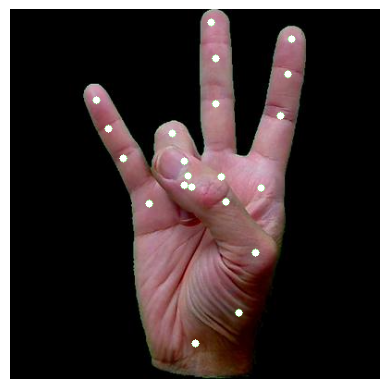

Landmarks:
[0.5004634261131287, 0.9049205780029297, 7.608869623254577e-07]
[0.6188706159591675, 0.8209400773048401, -0.09005366265773773]
[0.6640430092811584, 0.6593465805053711, -0.12033131718635559]
[0.5830232501029968, 0.5214057564735413, -0.14393408596515656]
[0.48084166646003723, 0.45008888840675354, -0.16288939118385315]
[0.6787438988685608, 0.4832218587398529, -0.060711830854415894]
[0.7309462428092957, 0.2899051606655121, -0.09304177016019821]
[0.7509928941726685, 0.1758374571800232, -0.11348720639944077]
[0.7608997821807861, 0.08080793917179108, -0.1306365728378296]
[0.5720964074134827, 0.4533798396587372, -0.05809243023395538]
[0.5569555163383484, 0.2555871307849884, -0.10494331270456314]
[0.5551141500473022, 0.13431890308856964, -0.14652444422245026]
[0.5428345799446106, 0.03546726703643799, -0.17350585758686066]
[0.47135934233665466, 0.47605574131011963, -0.06584430485963821]
[0.4377613365650177, 0.33507412672042847, -0.14207445085048676]
[0.47179749608039856, 0.41221550107

In [61]:
import mediapipe as mp  # Import Mediapipe for hand landmark detection
from mediapipe.tasks import python  # Import Mediapipe task modules for more customization
from mediapipe.tasks.python import vision  # Import vision tasks for hand detection
import matplotlib.pyplot as plt  # Import plotting library for visualization

# Initialize the hand landmarker model
# BaseOptions defines the model file to be used
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')

# Define HandLandmarker options (we allow detecting up to 2 hands)
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)

# Create the hand landmarker detector object
detector = vision.HandLandmarker.create_from_options(options)

# Load an example image from the dataset and create a Mediapipe Image object
image = mp.Image.create_from_file("asl_dataset/7/hand1_7_dif_seg_5_cropped.jpeg")

# Detect hand landmarks in the image
detection_result = detector.detect(image)

# Visualize the hand landmarks on the image using the previously defined function
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

# Display the annotated image using matplotlib
plt.imshow(annotated_image)
plt.axis("off")  # Turn off axis for cleaner visualization
plt.show()

# Print the detected landmarks for the first hand (x, y, z coordinates for each landmark)
print('Landmarks:')
for landmark in detection_result.hand_landmarks[0]:
    print([landmark.x, landmark.y, landmark.z])  # Display each landmark's coordinates

# Output the total number of landmarks detected (should be 21 for a full hand detection)
landmarks_cnt = len(detection_result.hand_landmarks[0])
print(f'landmarks count: {landmarks_cnt}')


In [75]:
%%time
# Measure the time it takes to process the dataset

from PIL import Image, ImageOps  # Libraries to handle image processing

source_df = []  # Lists to store images and corresponding data
skipped_images = 0  # Counter for images where landmark detection fails

# Loop through each folder (representing a hand sign class) in the dataset
for folder in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, folder)

    if os.path.isdir(folder_path):
        # Loop through each image in the folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            if os.path.isfile(item_path):
                # Read the image and add a black border around it to help with landmark detection
                border_size = 100  # Border size for padding
                source_img = Image.open(item_path)  # Open the image using PIL
                img = np.array(ImageOps.expand(source_img, border=border_size, fill='black'))  # Add black border
                img = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)  # Convert to Mediapipe image format
                # Detect hand landmarks in the image
                detection_result = detector.detect(img)

                if len(detection_result.hand_landmarks) > 0:
                    # If landmarks are detected, annotate the image with landmarks
                    annotated_image = draw_landmarks_on_image(img.numpy_view(), detection_result)

                    # Remove the added border after detection
                    annotated_image = annotated_image[border_size:-border_size, border_size:-border_size]

                    # Extract the hand landmarks (x, y, z coordinates)
                    landmarks = [[lm.x, lm.y, lm.z] for lm in detection_result.hand_landmarks[0]]

                    # Append the image data, including the original and annotated images and landmarks, to the dataset
                    source_df += [{"class": folder,
                                  "image": np.array(source_img),  # Store the original image
                                  "annotated_image": annotated_image,  # Store the annotated image
                                  "landmarks": landmarks  # Store the hand landmarks
                                  }]
                else:
                    skipped_images += 1
# Print the number of successfully processed images and skipped images
print(f'images:{len(source_df)}  skipped:{skipped_images}')

# Convert the list of image data into a pandas DataFrame for easier manipulation later
source_df = pd.DataFrame(source_df)

images:2374  skipped:141
CPU times: user 52.4 s, sys: 1.16 s, total: 53.6 s
Wall time: 53.3 s


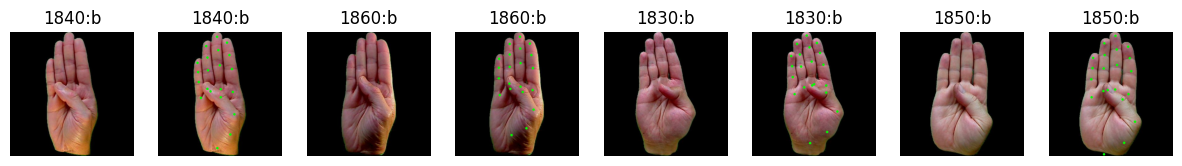

In [94]:
# Select 4 random image indices to check the original and annotated images
img_nums = (1840, 1860, 1830, 1850)  # Tuple of random images (indices) to visualize

# Set up the plotting space with a figure size of 15x3
plt.figure(figsize=(15, 3))

# Loop through the selected image indices
for i in range(4):
    # Get the row (data) corresponding to the selected image index from the dataframe
    row = source_df.iloc[img_nums[i]]

    # Plot the original image
    plt.subplot(1, 8, i*2+1)  # Create a subplot for the original image
    plt.imshow(row['image'])  # Show the original image
    plt.title(f"{img_nums[i]}:{row['class']}")  # Set the title to display the image index and class
    plt.axis("off")  # Hide the axis for a cleaner visualization

    # Plot the annotated image (with landmarks drawn)
    plt.subplot(1, 8, i*2+2)  # Create a subplot for the annotated image
    plt.imshow(row['annotated_image'])  # Show the image with landmarks drawn on it
    plt.title(f"{img_nums[i]}:{row['class']}")  # Set the title to display the image index and class
    plt.axis("off")  # Hide the axis for a cleaner visualization
plt.show()

In [77]:
# Print the first 10 records of the dataset to check the class labels and the hand landmarks
print(source_df[["class", "landmarks"]].head(10))

# Compute and print the number of records (images) available in each class
# This helps us understand the distribution of our dataset across the different hand signs
print(dict(source_df.groupby('class').size()))  # Group by class and count the number of images per class

  class                                          landmarks
0     r  [[0.4969189167022705, 0.7334566116333008, 6.62...
1     r  [[0.4969249963760376, 0.7476433515548706, 3.53...
2     r  [[0.5100224614143372, 0.7341774106025696, 3.28...
3     r  [[0.505344569683075, 0.7523855566978455, 1.030...
4     r  [[0.5071226358413696, 0.8205253481864929, 3.37...
5     r  [[0.5243200659751892, 0.823715329170227, 4.283...
6     r  [[0.5068349838256836, 0.781701385974884, 7.463...
7     r  [[0.5168796181678772, 0.7913377285003662, 6.99...
8     r  [[0.5158982276916504, 0.7657875418663025, 8.07...
9     r  [[0.5195639729499817, 0.7612033486366272, 3.59...
{'0': 61, '1': 67, '2': 70, '3': 70, '4': 67, '5': 70, '6': 60, '7': 63, '8': 64, '9': 68, 'a': 70, 'b': 70, 'c': 60, 'd': 70, 'e': 63, 'f': 70, 'g': 69, 'h': 69, 'i': 70, 'j': 61, 'k': 70, 'l': 70, 'm': 62, 'n': 65, 'o': 61, 'p': 64, 'q': 51, 'r': 66, 's': 70, 't': 65, 'u': 70, 'v': 69, 'w': 63, 'x': 63, 'y': 70, 'z': 63}


In [86]:
import os  # To check file size after saving

# Define the path where the compressed dataset will be saved
gz_file_path = 'hand_landmarks.pkl.gz'

# Save the pandas DataFrame (source_df) to a pickle file, compressing it with gzip
# Using gzip to compress the file helps reduce the file size, which is useful for large datasets
%time source_df.to_pickle(gz_file_path)

# Print the size of the saved file to verify the compression
# Display the file size in MB for better readability
print(f"File size: {os.path.getsize(gz_file_path) /1024/1024:.2f} MB")

CPU times: user 1min 7s, sys: 538 ms, total: 1min 8s
Wall time: 1min 8s
File size: 753.33 MB


In [91]:
# Measure the time it takes to load the dataset from the compressed pickle file
# This ensures the dataset was saved correctly and can be loaded efficiently
check_df = pd.read_pickle('hand_landmarks.pkl.gz')
print(check_df[["class", "landmarks"]].head(10))

  class                                          landmarks
0     r  [[0.4969189167022705, 0.7334566116333008, 6.62...
1     r  [[0.4969249963760376, 0.7476433515548706, 3.53...
2     r  [[0.5100224614143372, 0.7341774106025696, 3.28...
3     r  [[0.505344569683075, 0.7523855566978455, 1.030...
4     r  [[0.5071226358413696, 0.8205253481864929, 3.37...
5     r  [[0.5243200659751892, 0.823715329170227, 4.283...
6     r  [[0.5068349838256836, 0.781701385974884, 7.463...
7     r  [[0.5168796181678772, 0.7913377285003662, 6.99...
8     r  [[0.5158982276916504, 0.7657875418663025, 8.07...
9     r  [[0.5195639729499817, 0.7612033486366272, 3.59...
